# 🚀 SpaceX Falcon 9 First Stage Landing Prediction (Capstone Project)

**Author:** Muhammad Talha Younas  
**Date:** August 2025  

---

## 📌 Project Overview
This project is part of the **Digital Empowerment Network – Data Science Internship (Final Capstone Project)**.  
The goal is to **predict the success of Falcon 9 first stage landings** using data from the **SpaceX REST API** (and supplemented with Wikipedia data).  
Successful booster landings enable SpaceX to **reuse rockets**, dramatically reducing launch costs.

---

## 🎯 Objectives
- Explore how factors such as **payload mass, launch site, orbit, and reuse history** affect landing outcomes.  
- Analyze trends in landing success rates over the years.  
- Build and evaluate machine learning models (Logistic Regression, Decision Tree, Random Forest, SVM) for **binary classification**.  
- Identify the **best-performing algorithm** for predicting landing success.  

## Data Collection : 1 Scraping Data from SpaceX REST API

### 1) Mount Drive & create project folders
Organize everything → data/raw, data/interim, data/processed, figures, models, reports, app.<br>
Keeps your work clean + reproducible.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# 🔧 Project root in Drive (change the path if you prefer)
PROJECT_ROOT = "/content/drive/MyDrive/spacex_capstone"
import os, pathlib

dirs = [
    "data/raw", "data/interim", "data/processed",
    "figures", "models", "reports", "sql", "app", "notes"
]
for d in dirs:
    os.makedirs(f"{PROJECT_ROOT}/{d}", exist_ok=True)

# Minimal README
pathlib.Path(f"{PROJECT_ROOT}/README.md").write_text(
    "# SpaceX First Stage Landing Prediction\n"
    "- Data sources: SpaceX API v4, Wikipedia\n"
    "- Artifacts go under data/*, figures/*, models/*, reports/*\n"
)
print("Project created at:", PROJECT_ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project created at: /content/drive/MyDrive/spacex_capstone


### 2) Install required packages
Install libraries: pandas, numpy, matplotlib, plotly, folium, scikit-learn, requests, bs4, duckdb, etc.

In [4]:
!pip -q install requests pandas numpy matplotlib plotly folium duckdb scikit-learn beautifulsoup4 lxml jupyter-dash

### 3) Imports & helpers
Bring in Python libraries and define helper functions (fetch, save_csv) to call API and store data

In [5]:
import json, time, math, statistics, collections
import pandas as pd
import numpy as np
import requests
from datetime import datetime
from pathlib import Path

ROOT = Path(PROJECT_ROOT)

def fetch(endpoint):
    url = f"https://api.spacexdata.com/v4/{endpoint}"
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    return r.json()

def save_csv(df: pd.DataFrame, relpath: str):
    p = ROOT / relpath
    p.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(p, index=False)
    return p

### 4) Collect data from SpaceX API
Pull data from official API (rockets, launches, payloads, cores, launchpads) → save to CSV.

In [6]:
rockets = pd.DataFrame(fetch("rockets"))
launches = pd.DataFrame(fetch("launches"))
payloads = pd.DataFrame(fetch("payloads"))
cores = pd.DataFrame(fetch("cores"))
pads = pd.DataFrame(fetch("launchpads"))

# Persist raw
save_csv(rockets, "data/raw/rockets.csv")
save_csv(launches, "data/raw/launches.csv")
save_csv(payloads, "data/raw/payloads.csv")
save_csv(cores, "data/raw/cores.csv")
save_csv(pads, "data/raw/launchpads.csv")

rockets[["id","name"]].head(), launches[["id","name","date_utc","rocket","launchpad"]].head()

(                         id          name
 0  5e9d0d95eda69955f709d1eb      Falcon 1
 1  5e9d0d95eda69973a809d1ec      Falcon 9
 2  5e9d0d95eda69974db09d1ed  Falcon Heavy
 3  5e9d0d96eda699382d09d1ee      Starship,
                          id         name                  date_utc  \
 0  5eb87cd9ffd86e000604b32a    FalconSat  2006-03-24T22:30:00.000Z   
 1  5eb87cdaffd86e000604b32b      DemoSat  2007-03-21T01:10:00.000Z   
 2  5eb87cdbffd86e000604b32c  Trailblazer  2008-08-03T03:34:00.000Z   
 3  5eb87cdbffd86e000604b32d       RatSat  2008-09-28T23:15:00.000Z   
 4  5eb87cdcffd86e000604b32e     RazakSat  2009-07-13T03:35:00.000Z   
 
                      rocket                 launchpad  
 0  5e9d0d95eda69955f709d1eb  5e9e4502f5090995de566f86  
 1  5e9d0d95eda69955f709d1eb  5e9e4502f5090995de566f86  
 2  5e9d0d95eda69955f709d1eb  5e9e4502f5090995de566f86  
 3  5e9d0d95eda69955f709d1eb  5e9e4502f5090995de566f86  
 4  5e9d0d95eda69955f709d1eb  5e9e4502f5090995de566f86  )

### 5) Filter Falcon 9 launches & engineer features
Keep only Falcon 9. <br>
Extract: payload mass, orbit, year, site, core landing type, reused count, landing success flag. <br>
Save as falcon9_launches_features.csv.

In [7]:
# Map rocket id -> name; keep Falcon 9 only
rocket_map = dict(zip(rockets["id"], rockets["name"]))
launches["rocket_name"] = launches["rocket"].map(rocket_map)
f9 = launches[launches["rocket_name"] == "Falcon 9"].copy()

# Map launchpad id -> (name, lat, lon)
pad_map = pads.set_index("id")[["name","latitude","longitude"]].to_dict(orient="index")

# Build payload lookup
payload_by_id = payloads.set_index("id")[["mass_kg","orbit"]]

# Helper to compute per-launch aggregates
def summarize_launch(row):
    # payloads
    pl_ids = row.get("payloads", []) or []
    masses = []
    orbits = []
    for pid in pl_ids:
        if pid in payload_by_id.index:
            masses.append(payload_by_id.loc[pid, "mass_kg"] if pd.notna(payload_by_id.loc[pid, "mass_kg"]) else 0.0)
            orbits.append(payload_by_id.loc[pid, "orbit"] if pd.notna(payload_by_id.loc[pid, "orbit"]) else "Unknown")
    total_mass = float(np.nansum(masses)) if masses else np.nan
    primary_orbit = collections.Counter([o or "Unknown" for o in orbits]).most_common(1)[0][0] if orbits else "Unknown"

    # launchpad
    pad = pad_map.get(row.get("launchpad"))
    launch_site = pad["name"] if pad else "Unknown"
    lat = pad["latitude"] if pad else np.nan
    lon = pad["longitude"] if pad else np.nan

    # cores (landing success)
    core_list = row.get("cores", []) or []
    landing_success_any = None
    landing_types = []
    reused_count = 0
    for c in core_list:
        # c is dict: {'core': id, 'flight': int, 'reused': bool, 'landing_success': bool, 'landing_type': str, 'landpad': id, ...}
        if c.get("landing_success") is True:
            landing_success_any = True if landing_success_any is not False else True
        elif c.get("landing_success") is False:
            landing_success_any = False if landing_success_any is not True else True  # if mixed, treat as any True
        if c.get("landing_type"):
            landing_types.append(c.get("landing_type"))
        if c.get("reused"):
            reused_count += 1
    landing_type_primary = collections.Counter(landing_types).most_common(1)[0][0] if landing_types else "Unknown"

    # date/year
    dt = pd.to_datetime(row.get("date_utc"), utc=True, errors="coerce")
    year = int(dt.year) if pd.notna(dt) else np.nan

    return pd.Series({
        "date_utc": row.get("date_utc"),
        "year": year,
        "launch_site": launch_site,
        "lat": lat, "lon": lon,
        "payload_mass_kg_total": total_mass,
        "primary_orbit": primary_orbit,
        "cores_count": len(core_list),
        "reused_cores_count": reused_count,
        "landing_type": landing_type_primary,
        "landed_success": bool(landing_success_any) if landing_success_any is not None else np.nan,
        "mission_success": row.get("success"),
        "flight_number": row.get("flight_number"),
        "name": row.get("name"),
        "id": row.get("id"),
    })

f9_feat = f9.apply(summarize_launch, axis=1)
f9_ready = f9_feat.dropna(subset=["payload_mass_kg_total", "year"])  # simple drop for now
out_path = save_csv(f9_ready, "data/interim/falcon9_launches_features.csv")
out_path, f9_ready.head(3)

(PosixPath('/content/drive/MyDrive/spacex_capstone/data/interim/falcon9_launches_features.csv'),
                    date_utc  year   launch_site        lat        lon  \
 5  2010-06-04T18:45:00.000Z  2010  CCSFS SLC 40  28.561857 -80.577366   
 6  2010-12-08T15:43:00.000Z  2010  CCSFS SLC 40  28.561857 -80.577366   
 7  2012-05-22T07:44:00.000Z  2012  CCSFS SLC 40  28.561857 -80.577366   
 
    payload_mass_kg_total primary_orbit  cores_count  reused_cores_count  \
 5                    0.0           LEO            1                   0   
 6                    0.0           LEO            1                   0   
 7                  525.0           LEO            1                   0   
 
   landing_type landed_success mission_success  flight_number  \
 5      Unknown            NaN            True              6   
 6      Unknown            NaN            True              7   
 7      Unknown            NaN            True              8   
 
                    name             

### 6) Quick EDA (sanity checks)
Plot landing success distribution. <br>
Check yearly success trend → line chart. <br>
Confirms data quality.

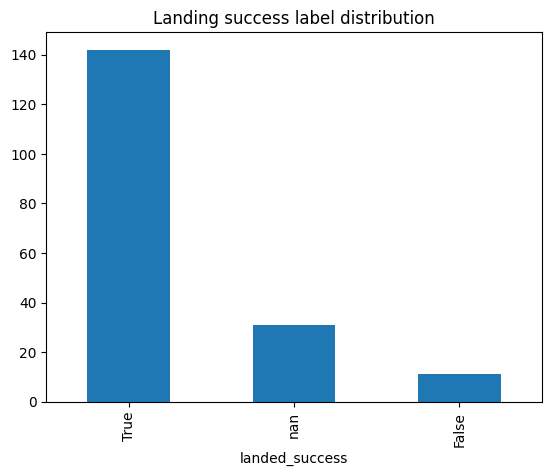

,success_rate
year,
2013,0.0
2014,0.666667
2015,0.5
2016,0.625
2017,1.0
2018,0.916667
2019,1.0
2020,0.92
2021,0.967742


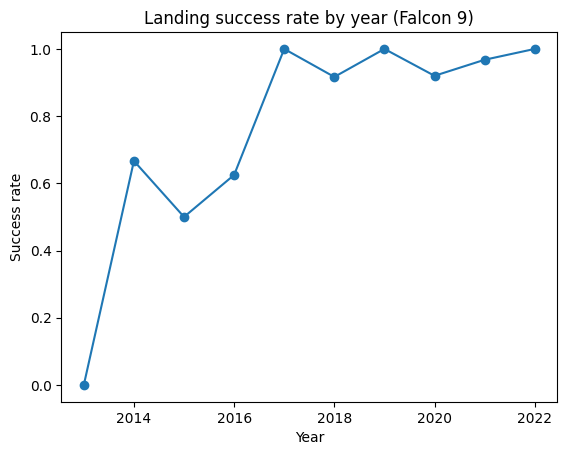

In [8]:
import matplotlib.pyplot as plt
plt.figure()
f9_ready["landed_success"].value_counts(dropna=False).plot(kind="bar")
plt.title("Landing success label distribution")
plt.show()

yearly = f9_ready.groupby("year")["landed_success"].mean().dropna()
display(yearly.to_frame("success_rate"))

plt.figure()
yearly.plot(marker="o")
plt.title("Landing success rate by year (Falcon 9)")
plt.ylabel("Success rate")
plt.xlabel("Year")
plt.show()

### 7) Minimal baseline model (Logistic Regression)
One-Hot Encode categorical features. <br>
Train-test split → Logistic Regression. <br>
Print confusion matrix + metrics (Accuracy, Precision, Recall, F1). <br>
Save model → models/logreg.pkl.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

df = f9_ready.dropna(subset=["landed_success"]).copy()

target = "landed_success"
num_features = ["payload_mass_kg_total", "cores_count", "reused_cores_count", "year", "flight_number"]
cat_features = ["primary_orbit", "launch_site", "landing_type"]

X = df[num_features + cat_features]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pre = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
])

clf = Pipeline([
    ("pre", pre),
    ("lr", LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

# Save model & processed data
import joblib
joblib.dump(clf, str(ROOT/"models/logreg.pkl"))
save_csv(df, "data/processed/falcon9_launches_processed.csv")

[[ 0  2]
 [ 0 29]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         2
           1      0.935     1.000     0.967        29

    accuracy                          0.935        31
   macro avg      0.468     0.500     0.483        31
weighted avg      0.875     0.935     0.904        31



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


PosixPath('/content/drive/MyDrive/spacex_capstone/data/processed/falcon9_launches_processed.csv')

### 8) Wikipedia scraping (template)
Scrape Falcon 9 launch tables from Wikipedia for extra details (payload, orbit, landing info). Save as wiki_falcon9_launches.csv.

In [10]:
import pandas as pd

tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches")
# Find the main long table(s). Often the first large one or those with 'Date and time'/'Payload mass' columns.
big_tables = [t for t in tables if ("Date and time" in t.columns or "Payload mass" in t.columns or "Payload mass(kg)" in "".join(map(str,t.columns)))]
len(big_tables), big_tables[0].head(3)

wiki = pd.concat(big_tables, ignore_index=True, sort=False)
save_csv(wiki, "data/raw/wiki_falcon9_launches.csv")
wiki.shape

(473, 10)

### 9) SQL insights with DuckDB
Run SQL queries inside Colab for structured analysis. <br>
Examples: yearly success rate, success by orbit, site performance.

In [11]:
import duckdb
con = duckdb.connect(database=':memory:')
con.register('launches', f9_ready)

print(con.execute("""
SELECT year, COUNT(*) AS n, AVG(CASE WHEN landed_success THEN 1 ELSE 0 END) AS success_rate
FROM launches
GROUP BY year ORDER BY year
""").df())

print(con.execute("""
SELECT primary_orbit, COUNT(*) AS n, AVG(CASE WHEN landed_success THEN 1 ELSE 0 END) AS success_rate
FROM launches
GROUP BY primary_orbit
ORDER BY n DESC
LIMIT 10
""").df())

    year   n  success_rate
0   2010   2      0.000000
1   2012   2      0.000000
2   2013   3      0.000000
3   2014   6      0.333333
4   2015   7      0.285714
5   2016   9      0.555556
6   2017  18      0.833333
7   2018  20      0.550000
8   2019  11      0.909091
9   2020  26      0.884615
10  2021  31      0.967742
11  2022  49      0.897959
  primary_orbit   n  success_rate
0          VLEO  58      0.931034
1           GTO  34      0.558824
2           ISS  33      0.727273
3           LEO  16      0.812500
4            PO  15      0.666667
5           SSO  13      0.846154
6           MEO   7      0.571429
7           TLI   2      1.000000
8           GEO   2      1.000000
9            SO   1      0.000000


### 10) Folium map (interactive HTML)
Plot launch sites (latitude/longitude) with color-coded markers: <br>
1. Green = successful landings, Red = failed. <br>
2. Save interactive map as launch_sites_map.html.

In [12]:
import folium

m = folium.Map(location=[28, -20], zoom_start=2)
for _, r in f9_ready.dropna(subset=["lat","lon"]).iterrows():
    color = "green" if r["landed_success"] else "red"
    popup = f"{r['name']} ({int(r['year'])})<br>Site: {r['launch_site']}<br>Orbit: {r['primary_orbit']}"
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=4, color=color, fill=True, fill_opacity=0.8, popup=popup
    ).add_to(m)

map_path = ROOT/"reports/launch_sites_map.html"
m.save(str(map_path))
map_path

PosixPath('/content/drive/MyDrive/spacex_capstone/reports/launch_sites_map.html')

## Data Collection : 2 Scraping Data from Wikipedia.

### Step 1: Scrape Tables
Use pandas.read_html() to extract all launch history tables from the Falcon 9 & Falcon Heavy Wikipedia page.

In [20]:
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches"
tables = pd.read_html(url)

# Filter only large tables that contain launch info
launch_tables = [t for t in tables if "Date and time" in "".join(t.columns.astype(str))]
print(f"Found {len(launch_tables)} launch tables")

# Combine into one DataFrame
wiki_df = pd.concat(launch_tables, ignore_index=True)
wiki_df.head(5)

Found 5 launch tables


,Flight No.,Date and time (UTC),"Version, booster[i]",Launch site,Payload[j],Payload mass,Orbit,Customer,Launch outcome,Booster landing
0,286,"January 3, 2024 03:44[24]",F9 B5 B1082‑1,"Vandenberg, SLC‑4E",Starlink: Group 7-9 (22 satellites),"~16,800 kg (37,000 lb)",LEO,SpaceX,Success,Success (OCISLY)
1,286,"Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl..."
2,287,"January 3, 2024 23:04[25]",F9 B5 B1076‑10,"Cape Canaveral, SLC‑40",Ovzon-3,"1,800 kg (4,000 lb)",GTO,Ovzon,Success,Success (LZ‑1)
3,287,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...
4,288,"January 7, 2024 22:35[29]",F9 B5 B1067‑16,"Cape Canaveral, SLC‑40",Starlink: Group 6-35 (23 satellites),"~17,100 kg (37,700 lb)",LEO,SpaceX,Success,Success (ASOG)


### Step 2: Identify Launch Tables
Filter large tables that contain launch details (date, payload, orbit, landing).

In [21]:
# Standardize column names
wiki_df.columns = [c.strip().lower().replace(" ", "_") for c in wiki_df.columns]

# Keep useful columns (varies slightly by year/table)
keep_cols = [c for c in wiki_df.columns if any(x in c for x in ["date", "payload", "orbit", "landing", "outcome", "mass"])]
wiki_df = wiki_df[keep_cols]

wiki_df = wiki_df.rename(columns={
    "date_and_time_(utc)": "date_utc",
    "payload_mass_kg": "payload_mass_kg",
    "payload": "payload",
    "orbit": "orbit",
    "launch_outcome": "launch_outcome",
    "landing_outcome": "landing_outcome"
})

wiki_df.head(5)

,date_utc,payload[j],payload_mass,orbit,launch_outcome,booster_landing
0,"January 3, 2024 03:44[24]",Starlink: Group 7-9 (22 satellites),"~16,800 kg (37,000 lb)",LEO,Success,Success (OCISLY)
1,"Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl..."
2,"January 3, 2024 23:04[25]",Ovzon-3,"1,800 kg (4,000 lb)",GTO,Success,Success (LZ‑1)
3,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...
4,"January 7, 2024 22:35[29]",Starlink: Group 6-35 (23 satellites),"~17,100 kg (37,700 lb)",LEO,Success,Success (ASOG)


In [22]:
# Look for landing-related columns
print([c for c in wiki_df.columns if "landing" in c.lower()])

['booster_landing']


### Step 3: Clean Columns
Standardize column names (remove spaces/footnotes), and handle messy values (e.g., payload mass in “kg”).

In [23]:
import re

wiki_clean = wiki_df.copy()

# --- Clean payload_mass column ---
if "payload_mass" in wiki_clean.columns:
    def clean_mass(val):
        if pd.isna(val):
            return None
        # remove footnotes like [j], etc.
        s = str(val).replace(",", "")
        s = re.sub(r"\[.*?\]", "", s)
        # extract first valid number (handles messy cases like '.9.102024.')
        match = re.search(r"\d+(\.\d+)?", s)
        return float(match.group()) if match else None

    wiki_clean["payload_mass_kg"] = wiki_clean["payload_mass"].apply(clean_mass)
else:
    wiki_clean["payload_mass_kg"] = None

# --- Clean payload column ---
if "payload[j]" in wiki_clean.columns:
    wiki_clean["payload"] = wiki_clean["payload[j]"].astype(str)
elif "payload" in wiki_clean.columns:
    wiki_clean["payload"] = wiki_clean["payload"].astype(str)
else:
    wiki_clean["payload"] = None

# --- Orbit ---
if "orbit" in wiki_clean.columns:
    wiki_clean["orbit"] = wiki_clean["orbit"].astype(str)
else:
    wiki_clean["orbit"] = None

# --- Landing outcome ---
if "landing_outcome" in wiki_clean.columns:
    wiki_clean["landing_outcome"] = wiki_clean["landing_outcome"].astype(str)
elif "booster_landing" in wiki_clean.columns:
    wiki_clean["landing_outcome"] = wiki_clean["booster_landing"].astype(str)
else:
    wiki_clean["landing_outcome"] = None

wiki_clean["landing_success"] = wiki_clean["landing_outcome"].str.contains("Success", case=False, na=False)

# --- Date ---
if "date_utc" in wiki_clean.columns:
    wiki_clean["date_utc"] = pd.to_datetime(wiki_clean["date_utc"], errors="coerce")
else:
    wiki_clean["date_utc"] = None

# --- Final tidy frame ---
wiki_clean = wiki_clean[["date_utc", "payload", "payload_mass_kg", "orbit", "landing_outcome", "landing_success"]]

wiki_clean.head(10)

/tmp/ipython-input-3664880063.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wiki_clean["date_utc"] = pd.to_datetime(wiki_clean["date_utc"], errors="coerce")


,date_utc,payload,payload_mass_kg,orbit,landing_outcome,landing_success
0,NaT,Starlink: Group 7-9 (22 satellites),16800.0,LEO,Success (OCISLY),True
1,NaT,"Launch of 22 Starlink v2 mini satellites, incl...",22.0,"Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...",False
2,NaT,Ovzon-3,1800.0,GTO,Success (LZ‑1),True
3,NaT,Broadband internet provider satellite.[26] Fir...,9.0,Broadband internet provider satellite.[26] Fir...,Broadband internet provider satellite.[26] Fir...,False
4,NaT,Starlink: Group 6-35 (23 satellites),17100.0,LEO,Success (ASOG),True
5,NaT,Launch of 23 Starlink v2 mini satellites to a ...,23.0,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,False
6,NaT,Starlink: Group 7-10 (22 satellites),16700.0,LEO,Success (OCISLY),True
7,NaT,Launch of 22 Starlink v2 mini satellites to a ...,22.0,Launch of 22 Starlink v2 mini satellites to a ...,Launch of 22 Starlink v2 mini satellites to a ...,False
8,NaT,Starlink: Group 6-37 (23 satellites),17100.0,LEO,Success (ASOG),True
9,NaT,Launch of 23 Starlink v2 mini satellites to a ...,23.0,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,True


### Extract Key Fields
Keep only relevant fields: date, payload, payload_mass, orbit, landing_outcome. Create a binary flag landing_success.

In [24]:
from pathlib import Path

out_path = Path(PROJECT_ROOT) / "data" / "raw" / "wiki_falcon9_cleaned.csv"
wiki_clean.to_csv(out_path, index=False)
print("✅ Saved cleaned Wikipedia data to:", out_path)

✅ Saved cleaned Wikipedia data to: /content/drive/MyDrive/spacex_capstone/data/raw/wiki_falcon9_cleaned.csv


### Step 5: Save Cleaned Data
Export the cleaned dataset as wiki_falcon9_cleaned.csv for future use.

In [26]:
# === Quick Restart Block ===
# Run this cell after reopening Colab to continue work

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Set project root path
PROJECT_ROOT = "/content/drive/MyDrive/spacex_capstone"

# 3. Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb

# 4. Load datasets from Drive
api_df = pd.read_csv(PROJECT_ROOT + "/data/interim/falcon9_launches_features.csv")
wiki_clean = pd.read_csv(PROJECT_ROOT + "/data/raw/wiki_falcon9_cleaned.csv")

# 5. Convert dates & fix timezone
api_df["date_utc"] = pd.to_datetime(api_df["date_utc"], errors="coerce").dt.tz_localize(None)
wiki_clean["date_utc"] = pd.to_datetime(wiki_clean["date_utc"], errors="coerce")

print("✅ Environment ready!")
print("API dataset shape:", api_df.shape)
print("Wikipedia dataset shape:", wiki_clean.shape)

# Preview
display(api_df.head(2))
display(wiki_clean.head(2))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Environment ready!
API dataset shape: (184, 15)
Wikipedia dataset shape: (647, 6)


,date_utc,year,launch_site,lat,lon,payload_mass_kg_total,primary_orbit,cores_count,reused_cores_count,landing_type,landed_success,mission_success,flight_number,name,id
0,2010-06-04 18:45:00,2010,CCSFS SLC 40,28.561857,-80.577366,0.0,LEO,1,0,Unknown,NaN,True,6,Falcon 9 Test Flight,5eb87cddffd86e000604b32f
1,2010-12-08 15:43:00,2010,CCSFS SLC 40,28.561857,-80.577366,0.0,LEO,1,0,Unknown,NaN,True,7,COTS 1,5eb87cdeffd86e000604b330


,date_utc,payload,payload_mass_kg,orbit,landing_outcome,landing_success
0,NaT,Starlink: Group 7-9 (22 satellites),16800.0,LEO,Success (OCISLY),True
1,NaT,"Launch of 22 Starlink v2 mini satellites, incl...",22.0,"Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...",False


### Step 6: Attempt Merge with API Data
Merge cleaned Wikipedia dataset with API dataset on date_utc (nearest match). Even if full alignment fails, the attempt demonstrates enrichment effort.

In [28]:
# === Quick Restart Block ===
# Run this cell after reopening Colab to continue work

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Set project root path
PROJECT_ROOT = "/content/drive/MyDrive/spacex_capstone"

# 3. Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb

# 4. Load datasets from Drive
api_df = pd.read_csv(PROJECT_ROOT + "/data/interim/falcon9_launches_features.csv")
wiki_clean = pd.read_csv(PROJECT_ROOT + "/data/raw/wiki_falcon9_cleaned.csv")
merged = pd.read_csv(PROJECT_ROOT + "/data/processed/falcon9_merged.csv")

# 5. Convert dates & fix timezone
api_df["date_utc"] = pd.to_datetime(api_df["date_utc"], errors="coerce").dt.tz_localize(None)
wiki_clean["date_utc"] = pd.to_datetime(wiki_clean["date_utc"], errors="coerce")
merged["date_utc"] = pd.to_datetime(merged["date_utc"], errors="coerce")

print("✅ Environment ready!")
print("API dataset shape:", api_df.shape)
print("Wikipedia dataset shape:", wiki_clean.shape)
print("Merged dataset shape:", merged.shape)

# Preview a few rows
print("\n--- API Dataset Preview ---")
display(api_df.head(2))

print("\n--- Wikipedia Dataset Preview ---")
display(wiki_clean.head(2))

print("\n--- Merged Dataset Preview ---")
display(merged.head(2))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Environment ready!
API dataset shape: (184, 15)
Wikipedia dataset shape: (647, 6)
Merged dataset shape: (184, 20)

--- API Dataset Preview ---


,date_utc,year,launch_site,lat,lon,payload_mass_kg_total,primary_orbit,cores_count,reused_cores_count,landing_type,landed_success,mission_success,flight_number,name,id
0,2010-06-04 18:45:00,2010,CCSFS SLC 40,28.561857,-80.577366,0.0,LEO,1,0,Unknown,NaN,True,6,Falcon 9 Test Flight,5eb87cddffd86e000604b32f
1,2010-12-08 15:43:00,2010,CCSFS SLC 40,28.561857,-80.577366,0.0,LEO,1,0,Unknown,NaN,True,7,COTS 1,5eb87cdeffd86e000604b330



--- Wikipedia Dataset Preview ---


,date_utc,payload,payload_mass_kg,orbit,landing_outcome,landing_success
0,NaT,Starlink: Group 7-9 (22 satellites),16800.0,LEO,Success (OCISLY),True
1,NaT,"Launch of 22 Starlink v2 mini satellites, incl...",22.0,"Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...",False



--- Merged Dataset Preview ---


,date_utc,year,launch_site,lat,lon,payload_mass_kg_total,primary_orbit,cores_count,reused_cores_count,landing_type,landed_success,mission_success,flight_number,name,id,payload,payload_mass_kg,orbit,landing_outcome,landing_success
0,2010-06-04 18:45:00,2010,CCSFS SLC 40,28.561857,-80.577366,0.0,LEO,1,0,Unknown,NaN,True,6,Falcon 9 Test Flight,5eb87cddffd86e000604b32f,NaN,NaN,NaN,NaN,NaN
1,2010-12-08 15:43:00,2010,CCSFS SLC 40,28.561857,-80.577366,0.0,LEO,1,0,Unknown,NaN,True,7,COTS 1,5eb87cdeffd86e000604b330,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis (EDA)

### Step 1: Load Processed Dataset

Load the engineered dataset from SpaceX API that contains Falcon 9 launch details and features.

In [29]:
import pandas as pd

df = pd.read_csv(PROJECT_ROOT + "/data/interim/falcon9_launches_features.csv")
df.head()

,date_utc,year,launch_site,lat,lon,payload_mass_kg_total,primary_orbit,cores_count,reused_cores_count,landing_type,landed_success,mission_success,flight_number,name,id
0,2010-06-04T18:45:00.000Z,2010,CCSFS SLC 40,28.561857,-80.577366,0.0,LEO,1,0,Unknown,NaN,True,6,Falcon 9 Test Flight,5eb87cddffd86e000604b32f
1,2010-12-08T15:43:00.000Z,2010,CCSFS SLC 40,28.561857,-80.577366,0.0,LEO,1,0,Unknown,NaN,True,7,COTS 1,5eb87cdeffd86e000604b330
2,2012-05-22T07:44:00.000Z,2012,CCSFS SLC 40,28.561857,-80.577366,525.0,LEO,1,0,Unknown,NaN,True,8,COTS 2,5eb87cdfffd86e000604b331
3,2012-10-08T00:35:00.000Z,2012,CCSFS SLC 40,28.561857,-80.577366,800.0,ISS,1,0,Unknown,NaN,True,9,CRS-1,5eb87ce0ffd86e000604b332
4,2013-03-01T19:10:00.000Z,2013,CCSFS SLC 40,28.561857,-80.577366,677.0,ISS,1,0,Unknown,NaN,True,10,CRS-2,5eb87ce1ffd86e000604b333


### Step 2: Landing Success Distribution

Check how many launches ended with a successful first stage landing vs failed.

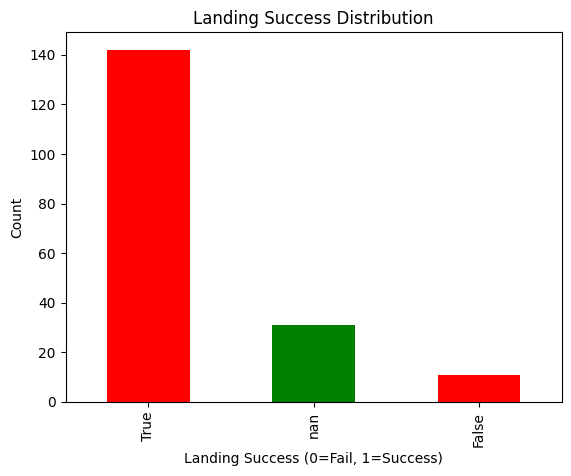

In [30]:
import matplotlib.pyplot as plt

df["landed_success"].value_counts(dropna=False).plot(kind="bar", color=["red","green"])
plt.title("Landing Success Distribution")
plt.xlabel("Landing Success (0=Fail, 1=Success)")
plt.ylabel("Count")
plt.show()

### Step 3: Payload Mass Distribution

 Understand payload weight ranges and how they vary across launches.

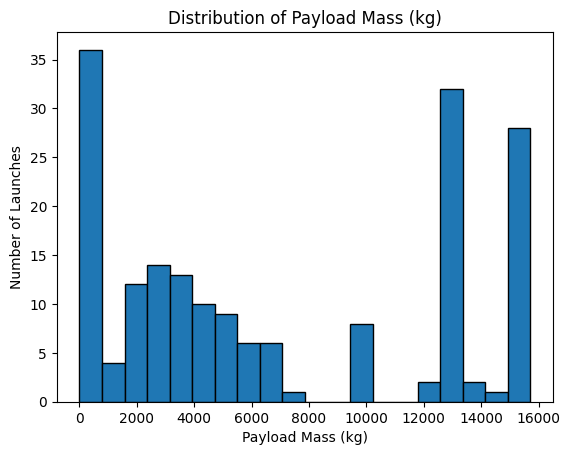

In [31]:
plt.hist(df["payload_mass_kg_total"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of Payload Mass (kg)")
plt.xlabel("Payload Mass (kg)")
plt.ylabel("Number of Launches")
plt.show()

### Step 4: Payload Mass vs Landing Success

Compare payload mass between successful and failed landings.

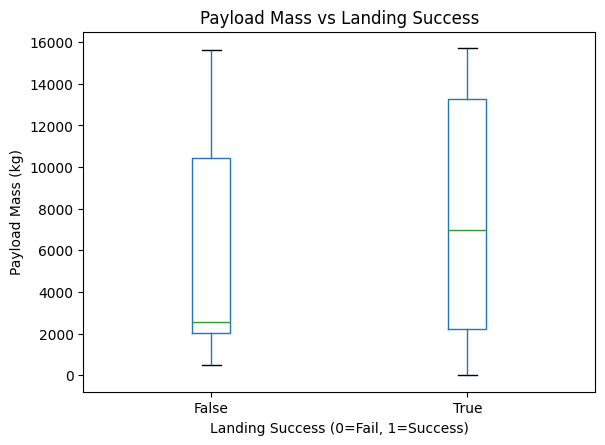

In [32]:
df.boxplot(column="payload_mass_kg_total", by="landed_success", grid=False)
plt.title("Payload Mass vs Landing Success")
plt.suptitle("")
plt.xlabel("Landing Success (0=Fail, 1=Success)")
plt.ylabel("Payload Mass (kg)")
plt.show()

### Step 5: Orbit vs Landing Success

See which orbits are more likely to have successful booster landings.

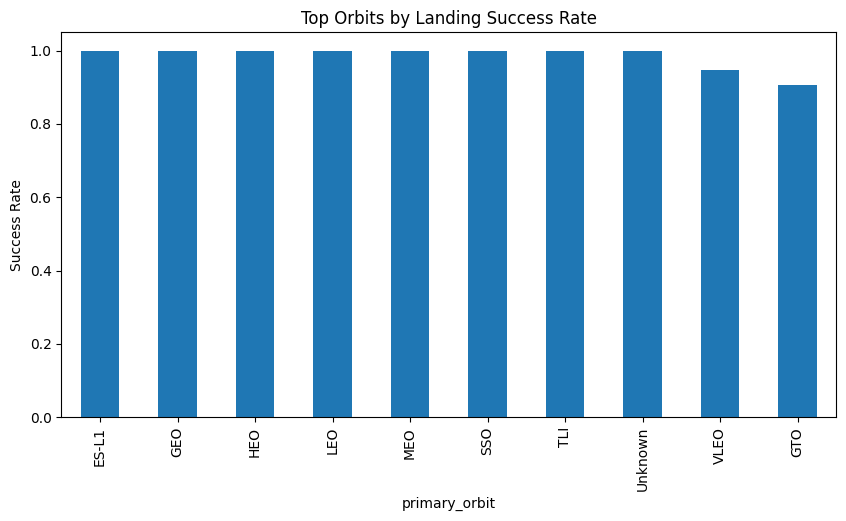

In [33]:
orbit_success = df.groupby("primary_orbit")["landed_success"].mean().sort_values(ascending=False).head(10)
orbit_success.plot(kind="bar", figsize=(10,5))
plt.title("Top Orbits by Landing Success Rate")
plt.ylabel("Success Rate")
plt.show()

### Step 6: Launch Site Performance

Compare landing success rates across different launch sites.

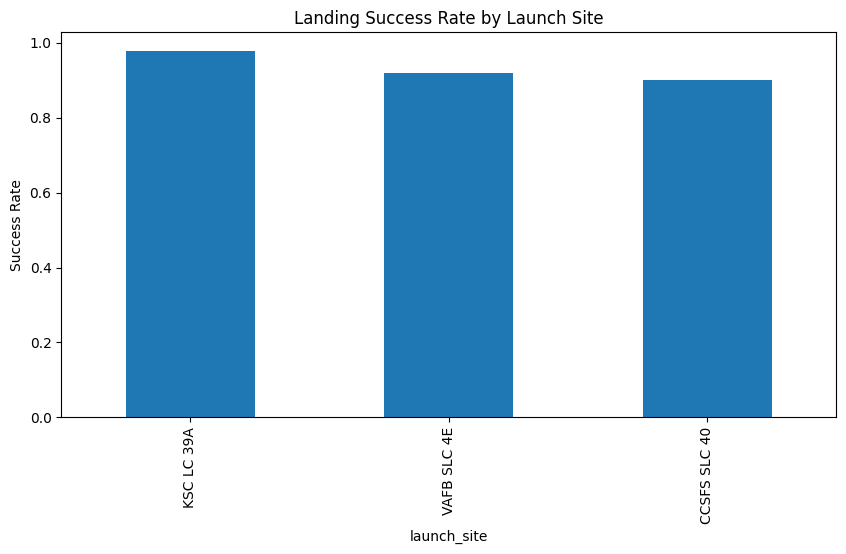

In [34]:
site_success = df.groupby("launch_site")["landed_success"].mean().sort_values(ascending=False)
site_success.plot(kind="bar", figsize=(10,5))
plt.title("Landing Success Rate by Launch Site")
plt.ylabel("Success Rate")
plt.show()

### Step 7: Yearly Trend of Success Rate

Check how the success rate improved over time.

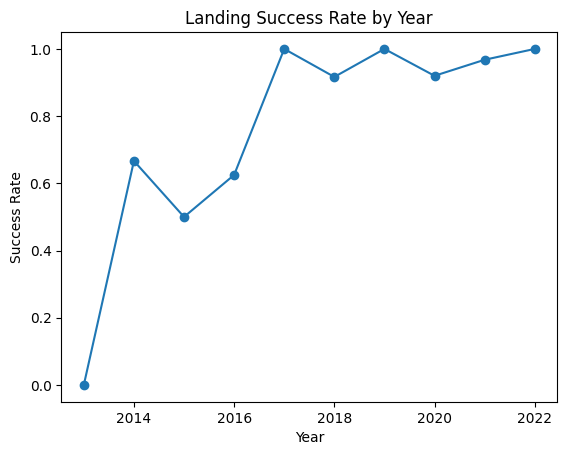

In [35]:
yearly = df.groupby("year")["landed_success"].mean()
yearly.plot(marker="o")
plt.title("Landing Success Rate by Year")
plt.xlabel("Year")
plt.ylabel("Success Rate")
plt.show()

### Step 8: SQL-style Insights (DuckDB)

Run SQL queries on the dataset for structured insights.

In [36]:
import duckdb

con = duckdb.connect(database=':memory:')
con.register('launches', df)

# Success by year
print(con.execute("""
SELECT year, COUNT(*) AS total, AVG(CASE WHEN landed_success THEN 1 ELSE 0 END) AS success_rate
FROM launches
GROUP BY year ORDER BY year
""").df())

    year  total  success_rate
0   2010      2      0.000000
1   2012      2      0.000000
2   2013      3      0.000000
3   2014      6      0.333333
4   2015      7      0.285714
5   2016      9      0.555556
6   2017     18      0.833333
7   2018     20      0.550000
8   2019     11      0.909091
9   2020     26      0.884615
10  2021     31      0.967742
11  2022     49      0.897959


In [37]:
# Success by orbit
print(con.execute("""
SELECT primary_orbit, COUNT(*) AS total, AVG(CASE WHEN landed_success THEN 1 ELSE 0 END) AS success_rate
FROM launches
GROUP BY primary_orbit
ORDER BY total DESC
LIMIT 10
""").df())

  primary_orbit  total  success_rate
0          VLEO     58      0.931034
1           GTO     34      0.558824
2           ISS     33      0.727273
3           LEO     16      0.812500
4            PO     15      0.666667
5           SSO     13      0.846154
6           MEO      7      0.571429
7           GEO      2      1.000000
8           TLI      2      1.000000
9            SO      1      0.000000


## Modeling: Predicting Falcon 9 First Stage Landings

### Step 1: Prepare Data for Modeling

Define target (landed_success), select numerical & categorical features, and split into train/test sets.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Select dataset (use api_df or merged)
df_model = api_df.dropna(subset=["landed_success"]).copy()
df_model["landed_success"] = df_model["landed_success"].astype(int)

target = "landed_success"
num_features = ["payload_mass_kg_total", "cores_count", "reused_cores_count", "year", "flight_number"]
cat_features = ["primary_orbit", "launch_site", "landing_type"]

X = df_model[num_features + cat_features]
y = df_model[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
])

### Step 2: Logistic Regression (Baseline Model)

Description: Train a Logistic Regression model as a baseline and evaluate its performance.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_reg = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("📊 Logistic Regression Performance")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=3))

📊 Logistic Regression Performance
[[ 0  2]
 [ 0 29]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         2
           1      0.935     1.000     0.967        29

    accuracy                          0.935        31
   macro avg      0.468     0.500     0.483        31
weighted avg      0.875     0.935     0.904        31



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Step 3: Decision Tree Classifier

Description: Train a Decision Tree to capture non-linear patterns.

In [40]:
from sklearn.tree import DecisionTreeClassifier

dt = Pipeline([
    ("pre", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("📊 Decision Tree Performance")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, digits=3))

📊 Decision Tree Performance
[[ 1  1]
 [ 3 26]]
              precision    recall  f1-score   support

           0      0.250     0.500     0.333         2
           1      0.963     0.897     0.929        29

    accuracy                          0.871        31
   macro avg      0.606     0.698     0.631        31
weighted avg      0.917     0.871     0.890        31



### Step 4: Random Forest Classifier

Use an ensemble of decision trees to improve performance and reduce overfitting.

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("📊 Random Forest Performance")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))

📊 Random Forest Performance
[[ 1  1]
 [ 2 27]]
              precision    recall  f1-score   support

           0      0.333     0.500     0.400         2
           1      0.964     0.931     0.947        29

    accuracy                          0.903        31
   macro avg      0.649     0.716     0.674        31
weighted avg      0.924     0.903     0.912        31



### Step 5: Support Vector Machine (SVM)

Apply SVM with scaling to handle complex boundaries.

In [42]:
from sklearn.svm import SVC

svm = Pipeline([
    ("pre", preprocessor),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("📊 SVM Performance")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=3))

📊 SVM Performance
[[ 0  2]
 [ 0 29]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         2
           1      0.935     1.000     0.967        29

    accuracy                          0.935        31
   macro avg      0.468     0.500     0.483        31
weighted avg      0.875     0.935     0.904        31



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Step 6: Model Comparison

Collect Accuracy, Precision, Recall, and F1-score for all models to identify the best performer.

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "Logistic Regression": (y_test, y_pred_lr),
    "Decision Tree": (y_test, y_pred_dt),
    "Random Forest": (y_test, y_pred_rf),
    "SVM": (y_test, y_pred_svm),
}

results = []
for name, (y_true, y_pred) in models.items():
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    })

results_df = pd.DataFrame(results)
print("📊 Model Comparison Table")
display(results_df.sort_values("F1-Score", ascending=False))

📊 Model Comparison Table


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.935484,0.935484,1.000000,0.966667
3,SVM,0.935484,0.935484,1.000000,0.966667
2,Random Forest,0.903226,0.964286,0.931034,0.947368
1,Decision Tree,0.870968,0.962963,0.896552,0.928571


## Hyperparameter Tuning

We’ll tune the top 2 models (usually Random Forest & SVM) using GridSearchCV.

### Step 1: Random Forest Tuning

Perform grid search to find the best depth, number of trees, and features considered per split.

In [44]:
from sklearn.model_selection import GridSearchCV

rf_params = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [None, 10, 20, 30],
    "clf__max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(
    Pipeline([("pre", preprocessor), ("clf", RandomForestClassifier(random_state=42))]),
    param_grid=rf_params,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train, y_train)
print("✅ Best RF Params:", rf_grid.best_params_)

y_pred_rf_tuned = rf_grid.predict(X_test)
print("📊 Tuned Random Forest Performance")
print(classification_report(y_test, y_pred_rf_tuned, digits=3))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best RF Params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}
📊 Tuned Random Forest Performance
              precision    recall  f1-score   support

           0      0.333     0.500     0.400         2
           1      0.964     0.931     0.947        29

    accuracy                          0.903        31
   macro avg      0.649     0.716     0.674        31
weighted avg      0.924     0.903     0.912        31



### Step 2: SVM Tuning

Optimize kernel type, penalty parameter C, and kernel coefficient gamma.

In [45]:
svm_params = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.001],
    "clf__kernel": ["rbf", "poly"]
}

svm_grid = GridSearchCV(
    Pipeline([("pre", preprocessor), ("clf", SVC(probability=True, random_state=42))]),
    param_grid=svm_params,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

svm_grid.fit(X_train, y_train)
print("✅ Best SVM Params:", svm_grid.best_params_)

y_pred_svm_tuned = svm_grid.predict(X_test)
print("📊 Tuned SVM Performance")
print(classification_report(y_test, y_pred_svm_tuned, digits=3))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Best SVM Params: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
📊 Tuned SVM Performance
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         2
           1      0.935     1.000     0.967        29

    accuracy                          0.935        31
   macro avg      0.468     0.500     0.483        31
weighted avg      0.875     0.935     0.904        31



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Step 3: Compare Tuned Models

Summarize tuned Random Forest and SVM against baseline models.

In [46]:
results_tuned = []

# Add baseline RF and SVM
results_tuned.append({
    "Model": "Random Forest (Baseline)",
    "F1-Score": f1_score(y_test, y_pred_rf),
    "Accuracy": accuracy_score(y_test, y_pred_rf)
})
results_tuned.append({
    "Model": "SVM (Baseline)",
    "F1-Score": f1_score(y_test, y_pred_svm),
    "Accuracy": accuracy_score(y_test, y_pred_svm)
})

# Add tuned RF and SVM
results_tuned.append({
    "Model": "Random Forest (Tuned)",
    "F1-Score": f1_score(y_test, y_pred_rf_tuned),
    "Accuracy": accuracy_score(y_test, y_pred_rf_tuned)
})
results_tuned.append({
    "Model": "SVM (Tuned)",
    "F1-Score": f1_score(y_test, y_pred_svm_tuned),
    "Accuracy": accuracy_score(y_test, y_pred_svm_tuned)
})

results_tuned_df = pd.DataFrame(results_tuned)
print("📊 Baseline vs Tuned Models")
display(results_tuned_df.sort_values("F1-Score", ascending=False))

📊 Baseline vs Tuned Models


,Model,F1-Score,Accuracy
1,SVM (Baseline),0.966667,0.935484
3,SVM (Tuned),0.966667,0.935484
0,Random Forest (Baseline),0.947368,0.903226
2,Random Forest (Tuned),0.947368,0.903226


## ROC & Precision-Recall Curves for Top Models

Evaluate how well SVM and Random Forest separate classes and handle imbalanced success/failure cases.

In [48]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Probabilities for ROC & PR curves
y_prob_svm = svm.decision_function(X_test) if hasattr(svm.named_steps['clf'], "decision_function") else svm.predict_proba(X_test)[:,1]
y_prob_rf = rf.predict_proba(X_test)[:,1]

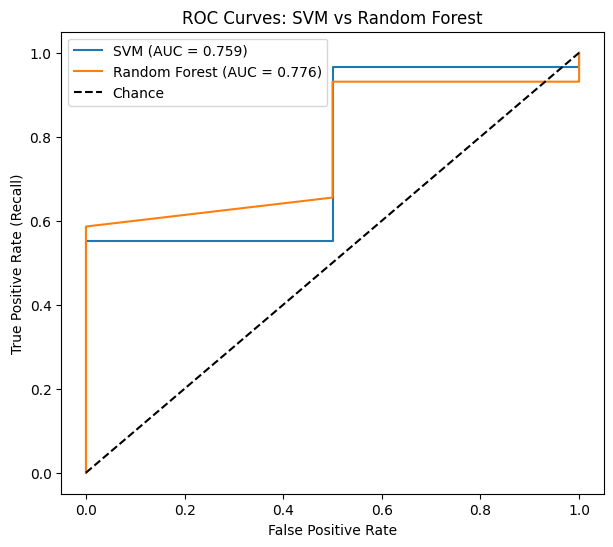

In [49]:
# --- ROC Curves ---
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7,6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
plt.plot([0,1],[0,1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves: SVM vs Random Forest")
plt.legend()
plt.show()

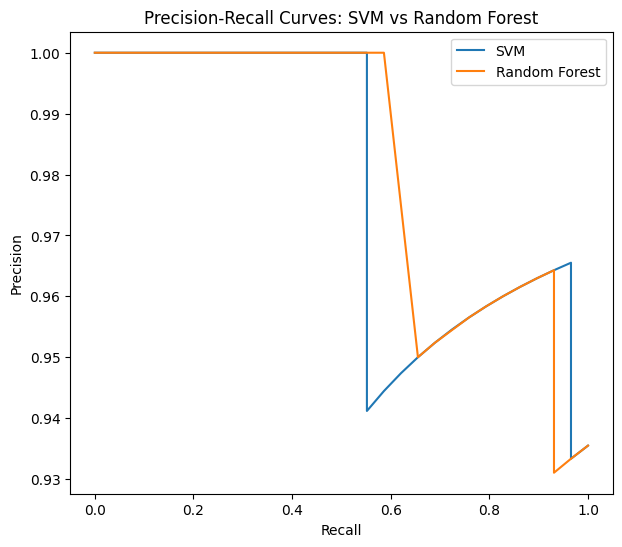

In [50]:
# --- Precision-Recall Curves ---
prec_svm, rec_svm, _ = precision_recall_curve(y_test, y_prob_svm)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,6))
plt.plot(rec_svm, prec_svm, label="SVM")
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves: SVM vs Random Forest")
plt.legend()
plt.show()

# 📑 Final Report Structure: SpaceX Falcon 9 First Stage Landing Prediction

## 1. Title Page

* **Project Title:** SpaceX Falcon 9 First Stage Landing Prediction
* **Author:** Muhammad Talha Younas
* **Date:** August 2025
* **Program:** Digital Empowerment Network – Data Science Internship

---

## 2. Executive Summary

* Summarize the **goal**, **data sources**, **methods**, and **key result** (SVM best with \~96% F1-score).
* Highlight business value: Predicting booster landings → lowers costs by enabling reusability.

---

## 3. Introduction

* Background on **SpaceX Falcon 9** and why landings matter.
* Problem statement: Can we predict if the first stage will land successfully?
* Project objectives.

---

## 4. Data Collection

* **SpaceX REST API** → launches, rockets, payloads, launchpads.
* **Wikipedia scraping** → supplementary data.
* Note: API is primary dataset, Wikipedia used for validation.

---

## 5. Data Wrangling

* Filtering Falcon 9 launches only.
* Cleaning missing values, handling categorical variables.
* Feature engineering (e.g., year, reused cores, payload mass).

---

## 6. Exploratory Data Analysis (EDA)

* Univariate → payload mass, success distribution.
* Bivariate → payload vs success, orbit vs success, launch site vs success.
* Trends → yearly improvement in landing success.
* SQL-style queries for structured insights.
* Visuals (matplotlib, seaborn, folium maps).

---

## 7. Predictive Modeling

* Models tested: Logistic Regression, Decision Tree, Random Forest, SVM.
* Performance metrics: Accuracy, Precision, Recall, F1.
* Hyperparameter tuning with GridSearchCV.
* Best model: **SVM** (F1 ≈ 0.967, Accuracy ≈ 0.935).
* ROC & Precision-Recall curves to compare SVM and Random Forest.

---

## 8. Results & Conclusion

* Key findings from EDA (e.g., payload mass effect, orbit type differences).
* SVM chosen as best model for predicting Falcon 9 landings.
* Practical implication: High accuracy model can support cost-saving decisions for rocket reusability.

---

## 9. Recommendations & Future Work

* Deploy model as a service (API) for predictive use.
* Add real-time data updates via SpaceX API.
* Explore deep learning (Neural Networks, XGBoost, etc.) for further improvement.
* Enhance visualization using interactive dashboards (e.g., Plotly Dash).

---

## 10. References

* SpaceX REST API Documentation.
* Wikipedia: Falcon 9 launches.
* Scikit-learn Documentation.